# Trabajo práctico 1: Bayes Ingenuo
En el presente trabajo práctico se introduce la implementación de redes
bayesianas. El trabajo practico consta de 120 puntos, donde 20 son extra
## Integrantes
- Marco Ferraro

In [3]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [4]:
# Set default tensor type to CUDA if available
if torch.cuda.is_available():
    print("CUDA is available! Training on GPU...")
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

## Implementación de la clasiﬁcación multiclase de imágenes con Bayes ingenuo usando histogramas

Para el presente ejercicio, se implementará la clasiﬁcación de imagenes
naturales con K = 10 clases. La Figura 1 muestra algunas observaciones
del conjunto de datos. El objetivo de su equipo de desarrollo es utilizar el teorema de Bayes para construir un modelo conocido como Bayes
ingenuo, el cual permita estimar la clase a la que pertenece una nueva
observación



### Carga de datos Cifar-10

Para la carga de datos se utilizó la librería cifar10, la cual contiene un conjunto de datos de 50,000 imágenes de 32x32 pixeles en 10 clases diferentes. Se utilizará en escalado de grises para simplificar el problema.

In [5]:
"""
    Carga el conjunto de datos CIFAR-10, convierte las imágenes a escala de grises y las agrupa en un tensor.

    Esta función descarga el conjunto de datos CIFAR-10, aplica una transformación para convertir las imágenes
    a escala de grises y luego agrupa todas las imágenes en un tensor único. También prepara un tensor con las
    etiquetas correspondientes a cada imagen.

    Parámetros:
    - is_train (bool, opcional): Un booleano que indica si se deben cargar los datos de entrenamiento (True) o
      los datos de prueba (False). Por defecto es True.

    Retorna:
    - cifar_trainset_tensor (Tensor): Un tensor que contiene todas las imágenes del conjunto de datos CIFAR-10
      convertidas a escala de grises y redondeadas a valores enteros en el rango de 0 a 255. Las imágenes están
      agrupadas en un tensor único a lo largo de la dimensión del lote.
    - cifar_labels (Tensor): Un tensor que contiene las etiquetas correspondientes a cada imagen en el tensor
      de imágenes.
"""


def load_cifar10_dataset(is_train=True):
  # Define a transformation to convert images to grayscale
  transforms_1 = transforms.Compose([
      transforms.ToTensor(),
      transforms.Grayscale(num_output_channels=1)  # Convert to grayscale
  ])
  cifar_trainset = datasets.CIFAR10(
      root='./data', train=is_train, download=True, transform=transforms_1)

  # Initialize an empty list to store batches
  all_data = []
  train_loader = torch.utils.data.DataLoader(
      cifar_trainset, batch_size=64, shuffle=True)
  # Iterate over the train_loader to fetch all batches
  for batch in train_loader:
      images, _ = batch  # Extract images from the batch
      all_data.append(images)

  # Concatenate all batches into a single tensor along the batch dimension
  cifar_trainset_tensor = torch.round(torch.cat(all_data, dim=0) * 255)
  cifar_labels = torch.tensor(cifar_trainset.targets)
  print("cifar_trainset_tensor shape ", cifar_trainset_tensor.shape)
  print("cifar_labels ", cifar_labels.shape)
  return (cifar_trainset_tensor, cifar_labels)


train_tensor, train_labels = load_cifar10_dataset(is_train=True)

train_tensor[1][0]

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([50000, 1, 32, 32])
cifar_labels  torch.Size([50000])


tensor([[  0.,   1.,   2.,  ..., 232., 229., 228.],
        [  0.,   1.,   2.,  ..., 233., 229., 227.],
        [  0.,   3.,   5.,  ..., 231., 229., 229.],
        ...,
        [  9.,  20.,  28.,  ...,   8.,   6.,  12.],
        [ 15.,  15.,  12.,  ...,   8.,   5.,  17.],
        [ 26.,  29.,  20.,  ...,  37.,  20.,  19.]])

In [6]:
train_tensor.shape

torch.Size([50000, 1, 32, 32])

In [7]:
train_labels.shape

torch.Size([50000])

Graficamos una imagen para visualizar y comprender el dataset. 

torch.Size([32, 32])


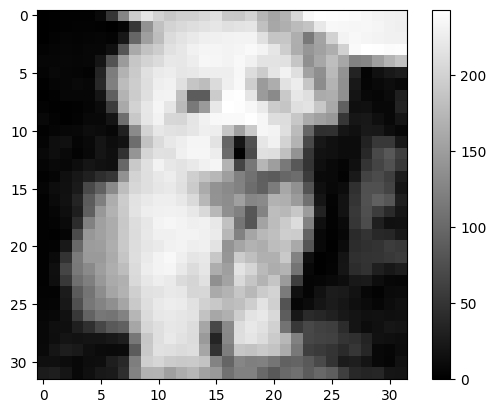

In [8]:
import matplotlib.pyplot as plt

# Asumiendo que train_tensor[1][0] es tu tensor de imagen en escala de grises
image_tensor = train_tensor[1][0]

print(image_tensor.shape)

# Verifica si el tensor está en un dispositivo CUDA y muévelo a CPU
if image_tensor.is_cuda:
    image_tensor = image_tensor.cpu()

# Convierte el tensor a un arreglo de numpy
image_numpy = image_tensor.numpy()

# Dado que es en escala de grises, elimina la dimensión del canal si existe
if image_tensor.dim() > 2:
    image_numpy = image_numpy.squeeze(0)

# Grafica la imagen
plt.imshow(image_numpy, cmap='gray')
plt.colorbar()
plt.show()

In [9]:
image_tensor = train_tensor
image_labels = train_labels

### Caluclo a priori p(t) para las clases

Implemente el cálculo de las probabilidades a priori p (t)
para las K = 10 clases en el conjunto de datos de entrenamiento en
la función calcular_probabilidad_priori. Realice tal calculo dentro de la
funcion train_model.

In [10]:
import torch

"""
Calcula las probabilidades a priori de etiquetas únicas en un conjunto de datos.

Args:
    labels (list o torch.Tensor): Etiquetas para calcular las probabilidades.

Returns:
    tuple (torch.Tensor, torch.Tensor): Probabilidades de cada etiqueta y etiquetas únicas.
"""


def calculate_priori_p_t(labels):
    # Convertir labels a un tensor si aún no lo es
    labels_tensor = torch.tensor(labels) if not isinstance(
        labels, torch.Tensor) else labels

    # Contar las ocurrencias de cada etiqueta
    label_counts = labels_tensor.bincount()

    # Calcular probabilidades dividiendo por el número total de etiquetas
    probabilities = label_counts.float() / labels_tensor.size(0)

    # Generar un tensor de etiquetas únicas ordenadas
    unique_labels = torch.arange(label_counts.size(0))

    # Filtrar etiquetas con conteo cero
    nonzero_indices = label_counts.nonzero().squeeze()
    probabilities = probabilities[nonzero_indices]
    unique_labels = unique_labels[nonzero_indices]

    return probabilities, unique_labels


# Ejemplo de uso de la función
# Asegúrate de definir 'labels' antes de llamar a la función
probabilities, unique_labels = calculate_priori_p_t(train_labels)

print("Probabilities:", probabilities)
print("Unique labels:", unique_labels)
print("Sum of probabilities:", probabilities.sum())
print("Shape of probabilities:", probabilities.shape)

Probabilities: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
Unique labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Sum of probabilities: tensor(1.0000)
Shape of probabilities: torch.Size([10])


Vemos que por defecto, todas las clases tienen la misma probabilidad a priori. Esto significa que estan balanceadas. Esto va a ser modificado en la seccion de entrenamiento.

### Pruebas de la implementación

Tenemos dos casos de pruebas para verficiar la implementacion de la funcion de probabilidades a priori. Generamos un tensor con un grupo de clases y hacemos un assert para verificar las posibilidades esperadas.  El primer caso contempla etiquetas consecutivas y el segundo caso etiquetas no consecutivas.

In [11]:
import torch


# Prueba con etiquetas consecutivas
consecutive_labels = torch.tensor([0, 1, 1, 2, 2, 2])
consecutive_probabilities, consecutive_unique_labels = calculate_priori_p_t(
    consecutive_labels)

assert torch.allclose(consecutive_probabilities, torch.tensor(
    [1/6, 2/6, 3/6])), "Probabilities do not match"
assert torch.equal(consecutive_unique_labels, torch.tensor(
    [0, 1, 2])), "Unique labels do not match"

# Prueba con etiquetas no consecutivas
non_consecutive_labels = torch.tensor([0, 0, 2, 2, 2, 5, 5, 5, 5])
non_consecutive_probabilities, non_consecutive_unique_labels = calculate_priori_p_t(
    non_consecutive_labels)

assert torch.allclose(non_consecutive_probabilities, torch.tensor(
    [2/9, 3/9, 4/9])), "Probabilities do not match"
assert torch.equal(non_consecutive_unique_labels, torch.tensor(
    [0, 2, 5])), "Unique labels do not match"

print("All tests passed successfully.")

All tests passed successfully.


 Cree un tensor de dimensiones dataset_densities D × Z × K, el cual represente las densi-
dades de cada pixel (1024 en total) para cada una de las intensi-
dades de pixel posibles.  Para realizar este calculo
solo se le permite usar un ciclo for, con una iteracion por cla-
se k, como maximo. Estime los valores de tal matriz usando el
conjunto de datos de entrenamiento

In [12]:
import torch

"""
    Calcula las probabilidades de intensidad de píxel para cada clase en un conjunto de datos de imágenes.

    Args:
        train_data (torch.Tensor): Tensor con los datos de entrenamiento de forma [num_images, image_height, image_width].
        train_labels (torch.Tensor): Tensor con las etiquetas de entrenamiento de forma [num_images].
        num_classes (int): Número de clases.

    Returns:
        torch.Tensor: Tensor de probabilidades de píxel con forma [D, Z, K], donde D es el número de píxeles por imagen,
                      Z es el número de posibles valores de intensidad (256 para imágenes en escala de grises), y K es el número de clases.
"""

def calculate_pixel_probability(train_data, train_labels, num_classes):
    # D: número de píxeles en una imagen (ancho x alto)
    # Z: número de posibles valores de intensidad (255 para blanco y negro)
    # K: número de clases
    D = train_data.shape[1] * train_data.shape[2]
    Z = 256  # blanco y negro, incluyendo todos los valores de 0 a 255
    K = num_classes

    # Inicializar el tensor de probabilidades con ceros
    pixel_probabilities = torch.zeros(D, Z, K)

    # Convertir train_data a long para usarlo en indexación
    train_data = train_data.long()

    # Aplanar las imágenes [num_images, D]
    flattened_images = train_data.view(-1, D)

    for class_id in range(K):
        # Filtrar imágenes por clase
        class_indices = (train_labels == class_id).nonzero().squeeze()
        class_images_flattened = flattened_images[class_indices]

        # Usar bincount para contar frecuencias de cada intensidad de píxel en todas las imágenes de la clase
        # Se necesita un tensor 2D para los índices: uno para los píxeles y otro para las imágenes
        indices = class_images_flattened + torch.arange(D) * Z
        indices = indices.view(-1)  # Convertir a 1D para bincount
        counts = torch.bincount(indices, minlength=Z*D).view(D, Z)

        # Normalizar las cuentas para obtener probabilidades
        pixel_probabilities[:, :, class_id] = counts.float(
        ) / counts.sum(dim=1, keepdim=True)

    return pixel_probabilities


num_images = 10000  # Número total de imágenes
image_height = 32  # Altura de las imágenes (H)
image_width = 32  # Anchura de las imágenes (W)
num_classes = 10  # Número de clases (K)

# Generar datos de entrenamiento de ejemplo
train_data = torch.randint(
    0, 256, (num_images, image_height, image_width), dtype=torch.float32)

# Generar etiquetas de ejemplo
train_labels = torch.randint(0, num_classes, (num_images,), dtype=torch.long)

print(train_data.shape)

# Calcular las probabilidades de los píxeles
pixel_probabilities = calculate_pixel_probability(
    train_data, train_labels, num_classes)

print(pixel_probabilities.shape)

torch.Size([10000, 32, 32])
torch.Size([1024, 256, 10])


In [13]:
print(pixel_probabilities[0][0][0])

tensor(0.0039)


### Pruebas unitarias

Se realizaran unos asserts con las dimensiones de la matriz esperadas. Esto se hara con datos de prueba.

In [14]:
# Ejemplo 1
num_images = 10000
image_height = 32
image_width = 32
num_classes = 10

train_data = torch.randint(
    0, 256, (num_images, image_height, image_width), dtype=torch.float32)
train_labels = torch.randint(0, num_classes, (num_images,), dtype=torch.long)

pixel_probabilities = calculate_pixel_probability(
    train_data, train_labels, num_classes)

D = image_height * image_width
Z = 256
K = num_classes
expected_shape = (D, Z, K)

assert pixel_probabilities.shape == expected_shape, f"La forma esperada es {expected_shape}, pero se obtuvo {pixel_probabilities.shape}"

print(f"La forma de pixel_probabilities es: {pixel_probabilities.shape}")

La forma de pixel_probabilities es: torch.Size([1024, 256, 10])


In [15]:
# Ejemplo 2
num_images = 5000
image_height = 28
image_width = 28
num_classes = 5

train_data = torch.randint(
    0, 256, (num_images, image_height, image_width), dtype=torch.float32)
train_labels = torch.randint(0, num_classes, (num_images,), dtype=torch.long)

pixel_probabilities = calculate_pixel_probability(
    train_data, train_labels, num_classes)

D = image_height * image_width
Z = 256
K = num_classes
expected_shape = (D, Z, K)

assert pixel_probabilities.shape == expected_shape, f"La forma esperada es {expected_shape}, pero se obtuvo {pixel_probabilities.shape}"

print(f"La forma de pixel_probabilities es: {pixel_probabilities.shape}")

La forma de pixel_probabilities es: torch.Size([784, 256, 5])


In [16]:
def calculate_histograms(images, labels, n_classes, n_intensity_levels=256):
    # n_intensity_levels es 256 para imágenes en escala de grises (0-255)
    histograms = torch.zeros(n_classes, n_intensity_levels)

    for class_index in range(n_classes):
        class_images = images[labels == class_index]
        # Aplana las imágenes de la clase y cuenta las frecuencias de cada nivel de intensidad
        flattened_images = class_images.flatten()
        counts = torch.histc(
            flattened_images, bins=n_intensity_levels, min=0, max=255)
        histograms[class_index] = counts

    return histograms

In [17]:
def histograms_to_probabilities(histograms):
    # Normaliza los histogramas para convertirlos en probabilidades
    probabilities = histograms / histograms.sum(dim=1, keepdim=True)
    return probabilities

In [18]:
"""
    Entrena un modelo generando histogramas de densidades de clase a partir de los datos de entrenamiento.

    Esta función calcula las probabilidades a priori de cada clase y las densidades de los datos de entrenamiento
    para cada clase. Luego, aplana las densidades de los datos para simplificar su estructura.

    Args:
    - train_data (Tensor): Un tensor que contiene los datos de entrenamiento. Se espera que tenga la forma
      adecuada para el modelo que se está entrenando.
    - train_labels (Tensor): Un tensor que contiene las etiquetas de los datos de entrenamiento. Cada etiqueta
      debe corresponder a los datos en `train_data`.
    - normalize (bool, opcional): Un booleano que indica si se deben normalizar las densidades de los datos.
      Por defecto es True.

    Returns:
    - dataset_densities (Tensor): Un tensor que contiene las densidades de los datos de entrenamiento
      para cada clase. Las densidades están aplanadas para simplificar su estructura.
    - priori_p_k (Tensor): Un tensor que contiene las probabilidades a priori de cada clase basadas en
      las etiquetas de entrenamiento.
"""

def train_model_histogram(train_data, train_labels, normalize=True):
    priori_p_k, unique_labels = calculate_priori_p_t(train_labels)
    # Reshape the data
    flattened_data = train_data.squeeze(1)
    # Check the new shape of the tensor
    dataset_densities = calculate_pixel_probability(flattened_data, train_labels, num_classes=len(
        unique_labels))

    return dataset_densities, priori_p_k


dataset_densities, priori_p_k = train_model_histogram(train_tensor, train_labels)

print(dataset_densities.shape)

torch.Size([1024, 256, 5])


## Grafique los histogramas de los primeros 5 pixeles para la clase 1 y 2. 
Siguen alguna distribucion conocida?

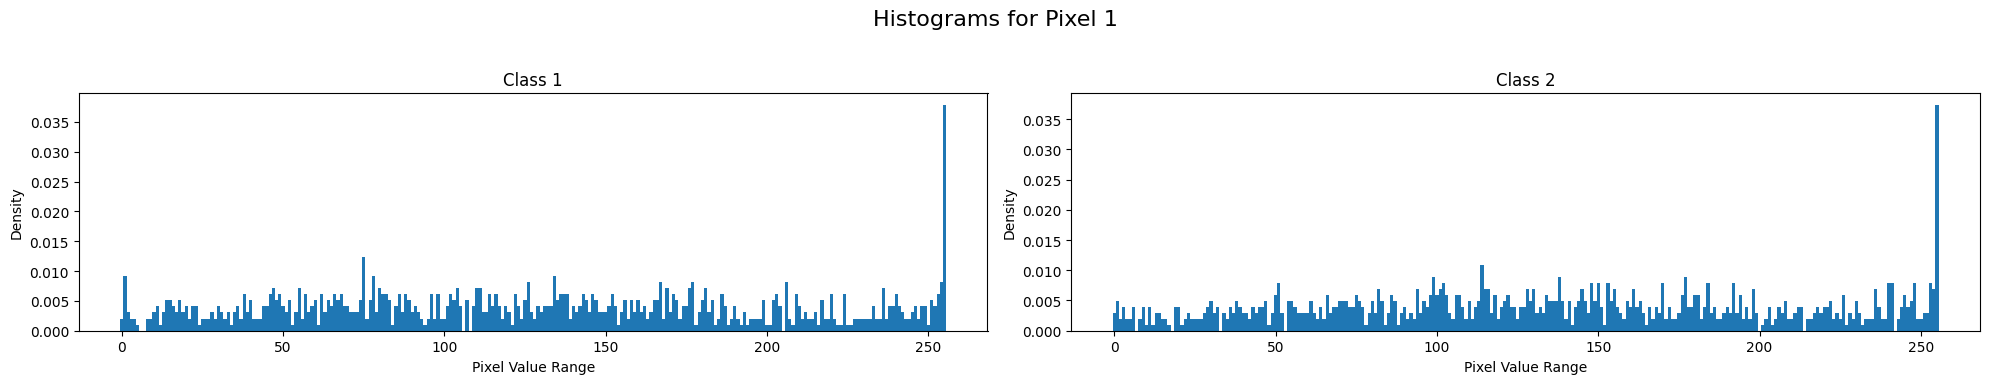

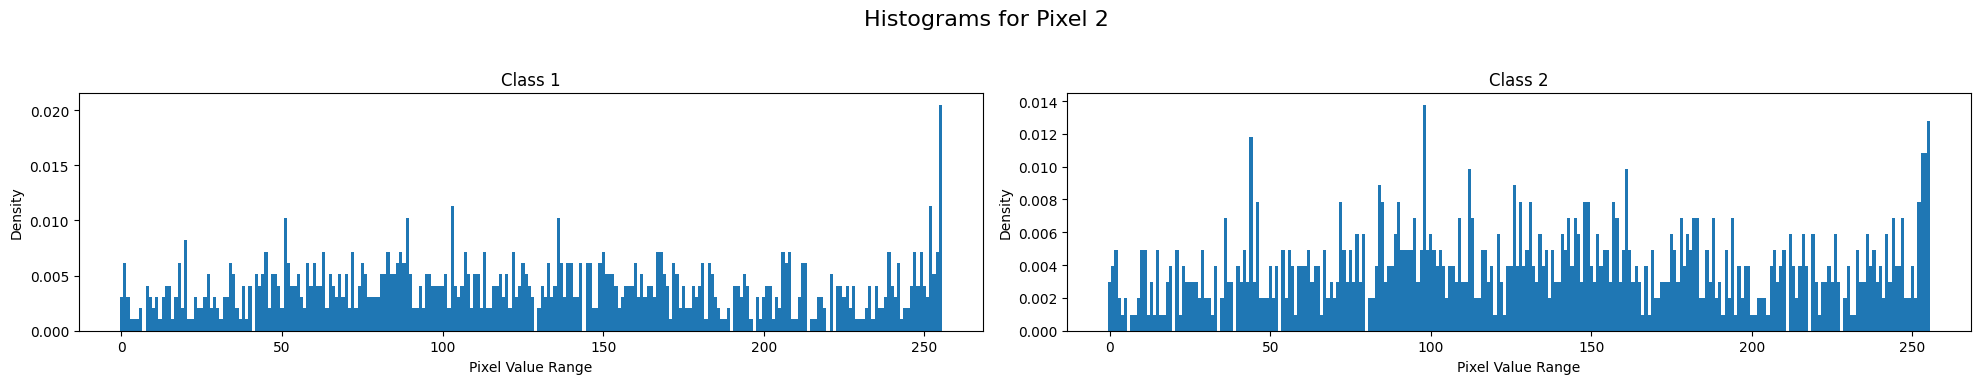

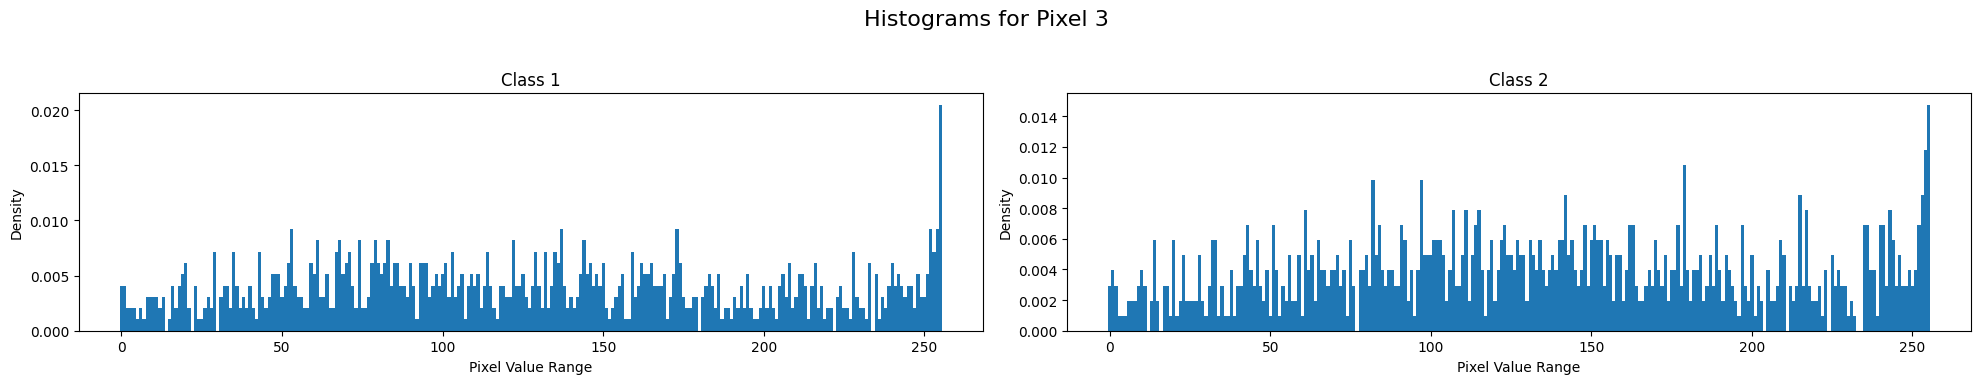

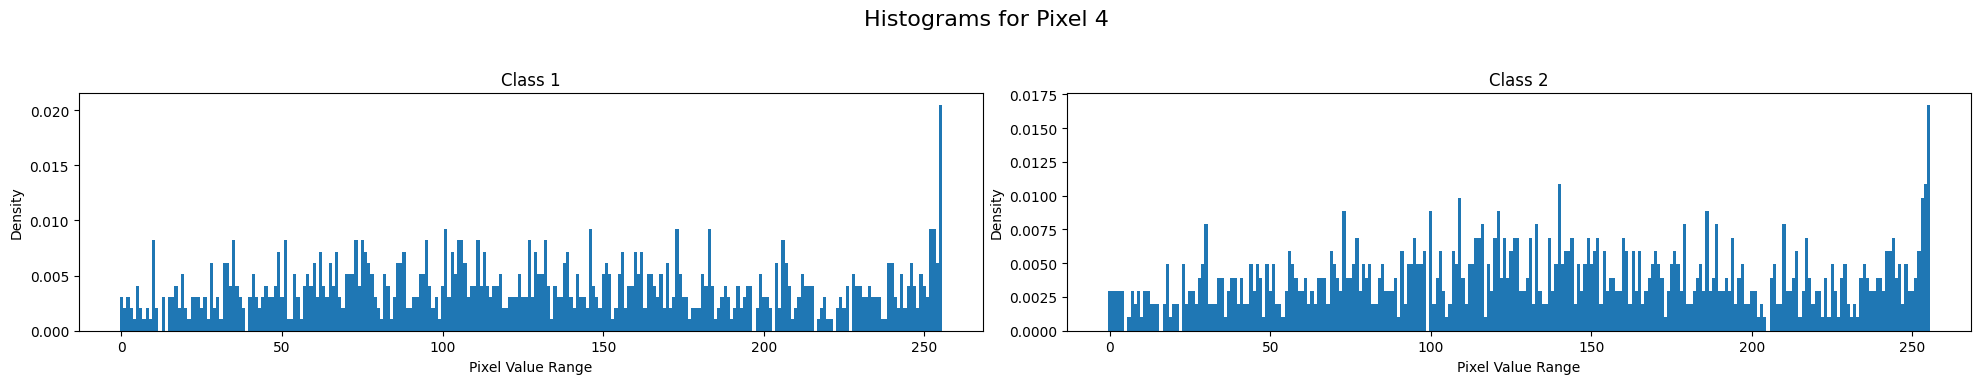

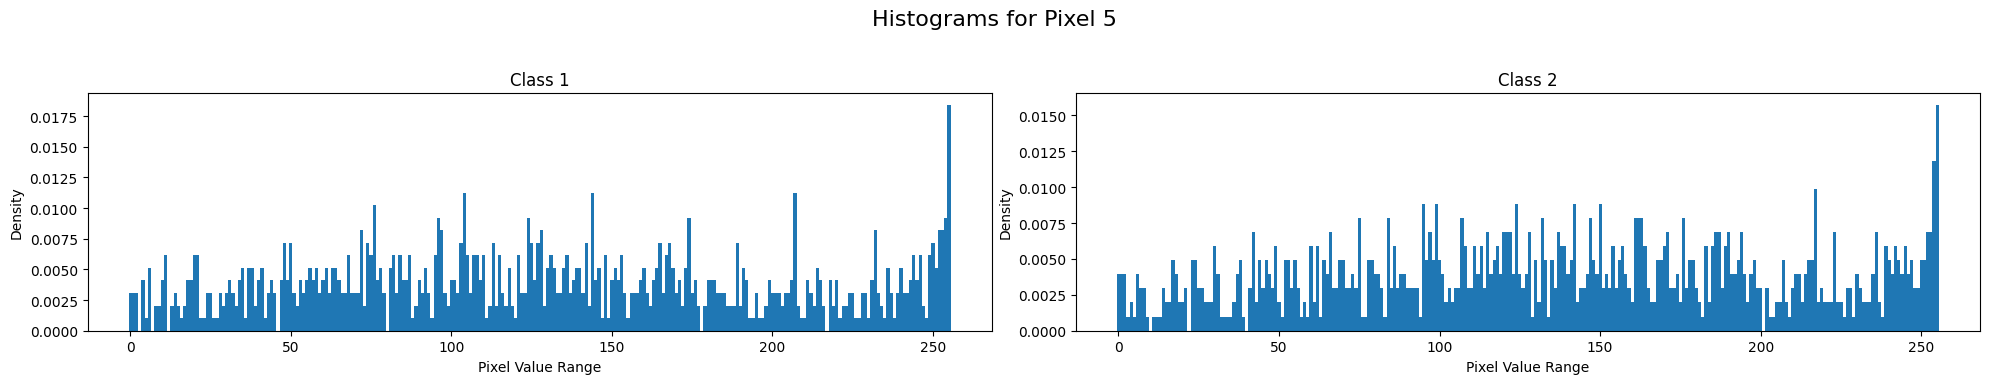

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Assuming you're using PyTorch tensors

"""
    Grafica histogramas para el número especificado de píxeles de una clase dada.

    Parámetros:
    - dataset_densities: Un tensor con forma [num_classes, 256, num_pixels].
    - class_index: El índice de la clase para la cual se graficarán los histogramas.
    - num_pixels: El número de píxeles para los cuales se graficarán histogramas.
    - bins: El número de contenedores para agrupar los valores de los píxeles.

    Esta función convierte el tensor a un arreglo de numpy si es un tensor de PyTorch, extrae las densidades
    para la clase especificada, calcula los bordes y anchos de los contenedores para la agregación y grafica
    histogramas para el número especificado de píxeles. Cada histograma muestra la densidad de los valores de
    píxeles dentro de rangos específicos para un píxel dado.
"""

def plot_pixel_densities(dataset_densities, pixel_index=0, bins=16, num_classes_to_plot=2):
    # Convertir el tensor a un arreglo numpy si es un tensor de PyTorch
    if isinstance(dataset_densities, torch.Tensor):
        dataset_densities = dataset_densities.numpy()

    # Calculate bin edges and widths for aggregation
    bin_edges = np.linspace(0, 256, bins + 1)
    bin_width = bin_edges[1] - bin_edges[0]

    # Graficar histogramas para el número especificado de clases
    fig, axs = plt.subplots(1, num_classes_to_plot, figsize=(20, 4))
    for i in range(num_classes_to_plot):
        # Extraer las densidades para el píxel y clase especificados
        pixel_densities = dataset_densities[pixel_index, :, i]
        # Agregar densidades de píxeles en contenedores
        binned_densities = np.histogram(
            np.arange(256), bins=bin_edges, weights=pixel_densities)[0]
        axs[i].bar(bin_edges[:-1], binned_densities, width=bin_width)
        axs[i].set_title(f'Class {i+1}')
        axs[i].set_xlabel('Pixel Value Range')
        axs[i].set_ylabel('Density')

    fig.suptitle(f'Histograms for Pixel {pixel_index + 1}', fontsize=16)

    # Ajustar el diseño para hacer espacio para el título
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_pixel_densities(dataset_densities, pixel_index=0,bins=256, num_classes_to_plot=2)
plot_pixel_densities(dataset_densities, pixel_index=1,bins=256, num_classes_to_plot=2)
plot_pixel_densities(dataset_densities, pixel_index=2, bins=256, num_classes_to_plot=2)
plot_pixel_densities(dataset_densities, pixel_index=3, bins=256, num_classes_to_plot=2)
plot_pixel_densities(dataset_densities, pixel_index=4, bins=256, num_classes_to_plot=2)

Al graficar los histogramas de los primeros 5 píxeles para las clases 1 y 2, se observa que las distribuciones de intensidades de píxeles no siguen necesariamente una distribución gaussiana. Sin embargo, se puede apreciar que los datos están distribuidos de manera relativamente uniforme, con excepción de un pico al final de la distribución.
Este pico al final de la distribución indica que, tanto para la clase 1 como para la clase 2, existe una mayor frecuencia de aparición de valores de intensidad de píxel cercanos a 0, lo que corresponde a tonos oscuros o negros. Esto sugiere que, para estos píxeles específicos, las imágenes de ambas clases tienden a tener regiones más oscuras o negras.
Es importante destacar que esta observación se basa únicamente en los primeros 5 píxeles analizados, y que el comportamiento de las distribuciones puede variar para otros píxeles o al considerar el conjunto completo de imágenes. Sin embargo, esta información puede ser útil para comprender mejor las características de las imágenes en cada clase y cómo se distribuyen las intensidades de píxeles.
Además, el hecho de que las distribuciones no sigan una forma gaussiana perfecta no es necesariamente un problema, ya que el enfoque basado en histogramas no asume una distribución específica. En cambio, este enfoque estima las densidades directamente a partir de los datos, lo que permite capturar distribuciones más complejas o irregulares.

In [20]:

import numpy as np

"""
    Estima la clase a la que pertenece una imagen de entrada utilizando el modelo de histogramas.

    Args:
        input_image (torch.Tensor): Tensor que contiene la imagen de entrada.
        dataset_densities (torch.Tensor): Tensor con las densidades de los píxeles para cada clase, de forma [D, Z, K],
            donde D es el número de píxeles, Z es el número de valores de intensidad (256 para escala de grises) y
            K es el número de clases.
        priori_p_k (torch.Tensor): Tensor con las probabilidades a priori de cada clase.

    Returns:
        torch.Tensor: Tensor con las verosimilitudes de cada clase para la imagen de entrada.
"""

def test_model_histogram(input_image, dataset_densities, priori_p_k):
    # Inicializar la variable de salida

    flattened_input_image = input_image.flatten()
    class_likelihoods = np.zeros(len(priori_p_k))

    for i in range(len(flattened_input_image)):
        pixel_intensity = int(flattened_input_image[i].item())
        for j in range(len(priori_p_k)):
            class_likelihoods[j] += torch.log(dataset_densities[i][pixel_intensity][j]) + torch.log(priori_p_k[j])

    return class_likelihoods



## Prueba Unitaria

Se realiza una prueba donde se evalua una prediccion esperada con una predicha.

In [21]:
test_specific_image = train_tensor[1][0]

# Obtener la etiqueta real de la imagen de prueba
true_label = train_labels[1].item()

# Realizar la predicción
likelihood_array = test_model_histogram(
    test_specific_image, dataset_densities, priori_p_k)
predicted_label = np.argmax(likelihood_array)

# Realizar el assert
assert predicted_label == true_label, f"La predicción {predicted_label} no coincide con la etiqueta real {true_label}"

# Si el assert no falla, imprimir los resultados
print(f"Etiqueta real: {true_label}")
print(f"Etiqueta predicha: {predicted_label}")

Etiqueta real: 3
Etiqueta predicha: 3


In [22]:
def test_model_batch_histogram(test_data, labels, dataset_densities, priori_p_k):
    y_truth = labels
    y_pred = []

    i = 0

    for image in test_data:
        i += 1

        flattened_image = image.flatten()
        likelihood_array = test_model_histogram(flattened_image, dataset_densities, priori_p_k)
        y_pred.append(np.argmax(likelihood_array))

    correct_predictions = np.sum(np.array(y_pred) == np.array(y_truth))
    accuracy = correct_predictions / len(y_truth)

    return accuracy, y_pred, y_truth



In [23]:
num_images = 10
image_height = 32
image_width = 32
num_classes = 2

    # Clase 0: todos los píxeles con valor 0
class_0_data = torch.zeros(num_images // 2, 1, image_height, image_width)
class_0_labels = torch.zeros(num_images // 2, dtype=torch.long)

# Clase 1: todos los píxeles con valor 255
class_1_data = torch.ones(num_images // 2, 1, image_height, image_width) * 255
class_1_labels = torch.ones(num_images // 2, dtype=torch.long)

# Combinar los datos y etiquetas
test_data = torch.cat([class_0_data, class_1_data], dim=0)
test_labels = torch.cat([class_0_labels, class_1_labels], dim=0)

# Calcular las densidades y probabilidades a priori
dataset_densities, priori_p_k = train_model_histogram(test_data, test_labels)

# Ejecutar la función a probar
accuracy, y_pred, y_truth = test_model_batch_histogram(test_data, test_labels, dataset_densities, priori_p_k)

# Verificar que la precisión sea 1.0 (100%)
assert accuracy == 1.0, f"La precisión esperada es 1.0, pero se obtuvo {accuracy}"

print("Prueba unitaria superada correctamente.")

Prueba unitaria superada correctamente.


## Prueba de Modelo

Entrene el modelo propuesto, con el conjunto de observacio-
nes contenido en la carpeta train, y reporte la tasa de aciertos al utilizar la función anteriormente implementadatest_model_batch_histogram. Veri-
fique y comente los resultados. 

**¿Cómo se puede corregir el problema detectado, según las herramientas matemáticas estudiadas en clase? Implemente tal enfoque y compruebe los resultados.**

### Respuesta

El problema es que los valores de predicción pueden tender a 0, lo que puede llevar a errores en la clasificación. Para corregir esto, se puede utilizar las propiedades de logaritmos en las operaciones de multiplicación, lo que genera terminando sumas en lugar de multiplicaciones.

In [24]:
train_data, train_labels = load_cifar10_dataset(is_train=True)

dataset_densities, priori_p_k = train_model_histogram(train_data, train_labels)

dataset_densities.shape

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([50000, 1, 32, 32])
cifar_labels  torch.Size([50000])


torch.Size([1024, 256, 10])

Entrene el modelo usando todos los datos de train, pero aho-
ra pruebelo con los datos en la carpeta de test, reporte los resultados y
comentelos

In [25]:
test_tensor, test_labels = load_cifar10_dataset(is_train=False)

accuracy, y_pred, y_truth = test_model_batch_histogram(
    test_tensor, test_labels, dataset_densities, priori_p_k)

print("Accuracy: ", accuracy)

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([10000, 1, 32, 32])
cifar_labels  torch.Size([10000])


KeyboardInterrupt: 

Particione los datos de forma aleatoria con 70 % de las obser-
vaciones para entrenamiento y 30 % para prueba (a partir de la carpeta
train). Calcule la tasa de aciertos para 10 corridas (idealmente 30), cada
una con una partición de entrenamiento y otra de prueba distintas. Re-
porte los resultados de las corridas en una tabla, además de la media y
desviación estándar de la tasa de aciertos para las 10 corridas. Para reali-
zar las particiones puede usar la libreria sklearn

In [ ]:
data, labels = load_cifar10_dataset(is_train=True)

data.shape

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(data, labels)

  # Shuffle the dataset

def shuffle_dataset(dataset):
      return DataLoader(dataset, shuffle=True)

accuracy_array = []

for epoch in range(15):

  shuffled_dataset_loader = shuffle_dataset(dataset)

  # Convert DataLoader back to TensorDataset
  shuffled_data = []
  shuffled_labels = []
  for d, l in shuffled_dataset_loader:
      shuffled_data.append(d)
      shuffled_labels.append(l)

  shuffled_data = torch.cat(shuffled_data)
  shuffled_labels = torch.cat(shuffled_labels)
  shuffled_dataset = TensorDataset(shuffled_data, shuffled_labels)

  # Split de dataset de forma aleatoria. Dejamos el 70% para entrenamiento y el 30% para pruebas
  train_size = int(0.7 * len(shuffled_dataset))
  test_size = len(shuffled_dataset) - train_size
  train_dataset, test_dataset = random_split(
      shuffled_dataset, [train_size, test_size])

  # Extract tensors from the subsets
  x_train = torch.cat([data for data, _ in DataLoader(train_dataset)])
  y_train = torch.cat([labels for _, labels in DataLoader(train_dataset)])
  x_test = torch.cat([data for data, _ in DataLoader(test_dataset)])
  y_test = torch.cat([labels for _, labels in DataLoader(test_dataset)])

  dataset_densities, priori_p_k = train_model_histogram(x_train, y_train)

  accuracy, y_pred, y_truth = test_model_batch_histogram(
      x_test, y_test, dataset_densities, priori_p_k)

  accuracy_array.append(accuracy)

  print("Accuracy: ", accuracy)
  print("Epoch: ", epoch)
  print()

print("Accuracy mean: ", np.mean(accuracy_array))
print("Accuracy std: ", np.std(accuracy_array))

##  Implementación de la clasiﬁcación multiclase de imágenes con Bayes ingenuo usando un modelo Gaussiano

In [26]:
import torch


def train_model_gaussian(train_data, train_labels, num_classes):
    """
    Entrena un modelo Gaussiano para estimar las medias y covarianzas de cada píxel
    para cada clase.

    Args:
        train_data (torch.Tensor): Tensor con los datos de entrenamiento de forma [N, 1, 32, 32].
        train_labels (torch.Tensor): Tensor con las etiquetas de entrenamiento de forma [N].
        num_classes (int): Número de clases.

    Returns:
        Mu_d_k (torch.Tensor): Tensor con las medias de cada píxel para cada clase de forma [D, K].
        Sigma_d_k (torch.Tensor): Tensor con las covarianzas de cada píxel para cada clase de forma [D, K].
    """
    N, _, H, W = train_data.shape  # N: número de imágenes, H: altura, W: anchura
    D = H * W  # Número de píxeles por imagen

    # Inicializar tensores para almacenar medias y covarianzas
    Mu_d_k = torch.zeros(D, num_classes)
    Sigma_d_k = torch.zeros(D, num_classes)

    # Aplanar las imágenes para que cada imagen sea un vector de tamaño D
    train_data_flat = train_data.view(N, D)

    for k in range(num_classes):
        # Obtener los datos de la clase k
        class_data = train_data_flat[train_labels == k]

        # Calcular medias y covarianzas para cada píxel de la clase k
        Mu_d_k[:, k] = class_data.mean(dim=0)
        Sigma_d_k[:, k] = class_data.var(dim=0)

    return Mu_d_k, Sigma_d_k



### Pruebas del entrenamiento del modelo

Para las pruebas del modelo, se utilizaran tensores creados aleatoriamiente para simular los datos de entrenamiento y testeo. Se espera que el resultado de la forma de las matrices sea de la forma esperada.

In [27]:
# Ejemplo de uso
# Suponiendo que train_data y train_labels ya están definidos y tienen las dimensiones correctas
train_data = torch.randn(50000, 1, 32, 32)  # Datos de ejemplo
train_labels = torch.randint(0, 10, (50000,))  # Etiquetas de ejemplo

Mu_d_k, Sigma_d_k = train_model_gaussian(
    train_data, train_labels, num_classes=10)

print(Mu_d_k.shape)  # Debería imprimir torch.Size([1024, 10])
print(Sigma_d_k.shape)  # Debería imprimir torch.Size([1024, 10])


assert Mu_d_k.shape == torch.Size(
    [1024, 10]), f"Expected shape [1024, 10], but got {Mu_d_k.shape}"
assert Sigma_d_k.shape == torch.Size(
    [1024, 10]), f"Expected shape [1024, 10], but got {Sigma_d_k.shape}"

print("Shapes are correct!")
print(Mu_d_k.shape)  # Debería imprimir torch.Size([1024, 10])
print(Sigma_d_k.shape)  # Debería imprimir torch.Size([1024, 10])

torch.Size([1024, 10])
torch.Size([1024, 10])
Shapes are correct!
torch.Size([1024, 10])
torch.Size([1024, 10])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import norm


import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import norm


def plot_histograms_and_gaussians(train_data, train_labels, Mu_d_k, Sigma_d_k, pixel_indices, classes):
    """
    Grafica los histogramas y los modelos Gaussianos para los píxeles especificados y las clases dadas en plots separados.

    Args:
        train_data (torch.Tensor): Tensor con los datos de entrenamiento de forma [N, 1, 32, 32].
        train_labels (torch.Tensor): Tensor con las etiquetas de entrenamiento de forma [N].
        Mu_d_k (torch.Tensor): Tensor con las medias de cada píxel para cada clase de forma [D, K].
        Sigma_d_k (torch.Tensor): Tensor con las covarianzas de cada píxel para cada clase de forma [D, K].
        pixel_indices (list): Lista de índices de los píxeles a graficar.
        classes (list): Lista de clases a graficar.
    """
    N, _, H, W = train_data.shape
    D = H * W
    train_data_flat = train_data.view(N, D)

    for pixel_index in pixel_indices:
        # Graficar histogramas
        plt.figure(figsize=(12, 6))
        for class_id in classes:
            class_data = train_data_flat[train_labels == class_id]
            pixel_values = class_data[:, pixel_index].numpy()
            plt.hist(pixel_values, bins=256, density=True, alpha=0.6,
                     label=f'Clase {class_id} - Píxel {pixel_index}')
        plt.xlabel('Intensidad del Píxel')
        plt.ylabel('Densidad')
        plt.legend()
        plt.title(f'Histograma para Píxel {pixel_index}')
        plt.show()

        # Graficar modelos Gaussianos
        plt.figure(figsize=(12, 6))
        for class_id in classes:
            mu = Mu_d_k[pixel_index, class_id].item()
            sigma = torch.sqrt(Sigma_d_k[pixel_index, class_id]).item()
            x = np.linspace(0, 255, 256)
            gaussian = norm.pdf(x, mu, sigma)
            plt.plot(
                x, gaussian, label=f'Gaussiana Clase {class_id} - Píxel {pixel_index}')
        plt.xlabel('Intensidad del Píxel')
        plt.gca().set_xticks([])  
        plt.gca().set_xticklabels([]) 
        plt.ylabel('Densidad')
        plt.legend()
        plt.title(f'Modelo Gaussiano para Píxel {pixel_index}')
        plt.show()



train_data, train_labels = load_cifar10_dataset(is_train=True)

# Calcular medias y varianzas
Mu_d_k, Sigma_d_k = train_model_gaussian(
    train_data, train_labels, num_classes=10)

# Graficar los histogramas y modelos Gaussianos para los primeros 5 píxeles de las clases 1 y 2
plot_histograms_and_gaussians(train_data, train_labels, Mu_d_k, Sigma_d_k, pixel_indices=[
                              0, 1, 2, 3, 4], classes=[1, 2])

In [ ]:
train_data.shape

In [ ]:
train_data[0][0][0][0]

In [28]:
import torch


def test_model_gaussian(input_torch, mu_d_k, sigma_d_k, priori_p_k):
    """
    Estima la clase a la que pertenece una observación utilizando el modelo Gaussiano.

    Args:
        input_torch (torch.Tensor): Tensor con la observación de forma [D].
        mu_d_k (torch.Tensor): Tensor con las medias de cada píxel para cada clase de forma [D, K].
        sigma_d_k (torch.Tensor): Tensor con las varianzas de cada píxel para cada clase de forma [D, K].
        priori_p_k (torch.Tensor): Tensor con las probabilidades a priori de cada clase.

    Returns:
        int: Índice de la clase estimada.
    """
    D = input_torch.shape[0]  # Número de píxeles
    K = mu_d_k.shape[1]  # Número de clases

    # Calcular la probabilidad posterior para cada clase
    log_posteriors = torch.zeros(K)
    for k in range(K):
        log_likelihood = torch.sum(torch.log(1 / torch.sqrt(2 * torch.pi * sigma_d_k[:, k])) -
                                   ((input_torch - mu_d_k[:, k]) ** 2) / (2 * sigma_d_k[:, k]))
        log_posteriors[k] = log_likelihood + torch.log(priori_p_k[k])

    # Estimar la clase con la mayor probabilidad posterior
    predicted_class = log_posteriors.argmax().item()

    return predicted_class

La prueba unitaria está diseñada para verificar la correcta implementación de la función test\_model\_batch\_gaussian, que estima las clases de un conjunto de datos de prueba utilizando un modelo Gaussiano.

In [ ]:
import torch

# Suponiendo que las funciones load_cifar10_dataset, train_model_gaussian, calculate_priori_p_t y test_model_gaussian ya están definidas

# Cargar los datos de prueba
test_tensor, test_labels = load_cifar10_dataset(is_train=False)

# Entrenar el modelo Gaussiano
mu_d_k, sigma_d_k = train_model_gaussian(
    test_tensor, test_labels, num_classes=10)

# Calcular las probabilidades a priori
priori_p_k = calculate_priori_p_t(test_labels)[0]

# Realizar la primera predicción
true_label_1 = test_labels[2].item()
predicted_class_1 = test_model_gaussian(
    test_tensor[2].flatten(), mu_d_k, sigma_d_k, priori_p_k)
assert predicted_class_1 == true_label_1, f"La predicción {predicted_class_1} no coincide con la etiqueta real {true_label_1}"

# Realizar la segunda predicción
true_label_2 = test_labels[3].item()
predicted_class_2 = test_model_gaussian(
    test_tensor[3].flatten(), mu_d_k, sigma_d_k, priori_p_k)
assert predicted_class_2 == true_label_2, f"La predicción {predicted_class_2} no coincide con la etiqueta real {true_label_2}"

# Imprimir los resultados
print(
    f"Primera predicción: La clase estimada es {predicted_class_1}, la clase real es {true_label_1}")
print(
    f"Segunda predicción: La clase estimada es {predicted_class_2}, la clase real es {true_label_2}")

In [41]:
def test_model_batch_gaussian(test_data, labels, mu_d_k, sigma_d_k, prior):
    """
    Estima las clases de un conjunto de datos de prueba utilizando el modelo Gaussiano.

    Args:
        test_data (torch.Tensor): Tensor con los datos de prueba de forma [N, D].
        labels (torch.Tensor): Tensor con las etiquetas reales de forma [N].
        mu_d_k (torch.Tensor): Tensor con las medias de cada píxel para cada clase de forma [D, K].
        sigma_d_k (torch.Tensor): Tensor con las varianzas de cada píxel para cada clase de forma [D, K].
        prior (torch.Tensor): Tensor con las probabilidades a priori de cada clase.

    Returns:
        float: Precisión del modelo.
        list: Lista de clases predichas.
        list: Lista de clases reales.
    """
    prediction_array = []

    for image in test_data:
        predicted_class = test_model_gaussian(image.flatten(), mu_d_k, sigma_d_k, prior)
        prediction_array.append(predicted_class)

    
    accuracy = np.sum(np.array(prediction_array) == np.array(labels)) / len(labels)

    return accuracy

Prueba Unitaria

In [ ]:
num_images = 20
image_height = 32
image_width = 32
num_classes = 2

    # Clase 0: imágenes negras
black_images = torch.zeros(num_images // 2, image_height * image_width)
black_labels = torch.zeros(num_images // 2, dtype=torch.long)

    # Clase 1: imágenes blancas
white_images = torch.ones(num_images // 2, image_height * image_width) * 255
white_labels = torch.ones(num_images // 2, dtype=torch.long)

    # Combinar los datos y etiquetas
test_data = torch.cat([black_images, white_images], dim=0)
test_labels = torch.cat([black_labels, white_labels], dim=0)

    # Entrenar el modelo Gaussiano con los mismos datos
mu_d_k = torch.zeros(image_height * image_width, num_classes)
sigma_d_k = torch.ones(image_height * image_width, num_classes)
mu_d_k[:, 1] = 255  # La media de la clase 1 es 255

    # Probabilidades a priori
priori_p_k = torch.tensor([0.5, 0.5])

    # Evaluar el modelo
accuracy, y_pred, y_truth = test_model_batch_gaussian(test_data, test_labels, mu_d_k, sigma_d_k, priori_p_k)

    # Verificar que la precisión sea 1.0 (100%)
assert accuracy == 1.0, f"La precisión esperada es 1.0, pero se obtuvo {accuracy}"

print("Prueba unitaria superada correctamente.")
print(f"Accuracy: {accuracy}")
print(f"Predicciones: {y_pred}")
print(f"Etiquetas reales: {y_truth}")

In [42]:
train_data, train_labels = load_cifar10_dataset(is_train=True)


mu_d_k, sigma_d_k = train_model_gaussian(train_data, train_labels, num_classes=10)
priori_p_k = calculate_priori_p_t(train_labels)[0]

test_data, test_labels = load_cifar10_dataset(is_train=False)

accuracy = test_model_batch_gaussian(test_data, test_labels, mu_d_k, sigma_d_k, priori_p_k)

print("Accuracy: ", accuracy)

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([50000, 1, 32, 32])
cifar_labels  torch.Size([50000])
Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([10000, 1, 32, 32])
cifar_labels  torch.Size([10000])
Accuracy:  0.0986


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split
data, labels = load_cifar10_dataset(is_train=True)


dataset = TensorDataset(data, labels)

# Shuffle the dataset
def shuffle_dataset(dataset):
    return DataLoader(dataset, shuffle=True)


for epoch in range(15):
  accuracy_array = []

  shuffled_dataset_loader = shuffle_dataset(dataset)

  # Convert DataLoader back to TensorDataset
  shuffled_data = []
  shuffled_labels = []
  for d, l in shuffled_dataset_loader:
      shuffled_data.append(d)
      shuffled_labels.append(l)

  shuffled_data = torch.cat(shuffled_data)
  shuffled_labels = torch.cat(shuffled_labels)
  shuffled_dataset = TensorDataset(shuffled_data, shuffled_labels)

  # Split de dataset de forma aleatoria. Dejamos el 70% para entrenamiento y el 30% para pruebas
  train_size = int(0.7 * len(shuffled_dataset))
  test_size = len(shuffled_dataset) - train_size
  train_dataset, test_dataset = random_split(
      shuffled_dataset, [train_size, test_size])

  # Extract tensors from the subsets
  x_train = torch.cat([data for data, _ in DataLoader(train_dataset)])
  y_train = torch.cat([labels for _, labels in DataLoader(train_dataset)])
  x_test = torch.cat([data for data, _ in DataLoader(test_dataset)])
  y_test = torch.cat([labels for _, labels in DataLoader(test_dataset)])

  mu_d_k, sigma_d_k = train_model_gaussian(x_train, y_train, num_classes=10)
  priori_p_k = calculate_priori_p_t(y_train)[0]


  prediction_array = []

  for image in x_test:
      predicted_class = test_model_gaussian(image.flatten(), mu_d_k, sigma_d_k, priori_p_k)
      prediction_array.append(predicted_class)

  
  accuracy = test_model_batch_gaussian(x_test, y_test, mu_d_k, sigma_d_k, priori_p_k)
  accuracy_array.append(accuracy)

  print("Accuracy: ", accuracy)
  print("Epoch: ", epoch)
  print()

print("Accuracy mean: ", np.mean(accuracy_array))
print("Accuracy std: ", np.std(accuracy_array))

In [ ]:
import torch
import numpy as np
from scipy.stats import norm


def train_model_kde(train_data, train_labels, num_classes, bandwidth=0.5):
    """
    Entrena un modelo KDE para estimar las densidades de cada píxel para cada clase.

    Args:
        train_data (torch.Tensor): Tensor con los datos de entrenamiento de forma [N, 1, 32, 32].
        train_labels (torch.Tensor): Tensor con las etiquetas de entrenamiento de forma [N].
        num_classes (int): Número de clases.
        bandwidth (float): Ancho de banda para el kernel Gaussiano.

    Returns:
        dataset_densities (torch.Tensor): Tensor con las densidades de cada píxel para cada clase de forma [D, K].
    """
    N, _, H, W = train_data.shape  # N: número de imágenes, H: altura, W: anchura
    D = H * W  # Número de píxeles por imagen
    K = num_classes  # Número de clases

    # Aplanar las imágenes para que cada imagen sea un vector de tamaño D
    train_data_flat = train_data.view(N, D)

    # Inicializar tensor para almacenar densidades
    dataset_densities = torch.zeros(D, K)

    for k in range(K):
        # Obtener los datos de la clase k
        class_data = train_data_flat[train_labels == k]

        # Calcular densidades para cada píxel de la clase k
        for d in range(D):
            pixel_values = class_data[:, d]
            dataset_densities[d, k] = kde_gaussian(pixel_values, bandwidth)

    return dataset_densities


def kde_gaussian(data, bandwidth):
    """
    Calcula la densidad de una distribución utilizando KDE con un kernel Gaussiano.

    Args:
        data (torch.Tensor): Tensor con los datos.
        bandwidth (float): Ancho de banda para el kernel Gaussiano.

    Returns:
        density (float): Densidad estimada.
    """
    kernel = norm(loc=data.mean(), scale=bandwidth)
    density = kernel.pdf(data).mean()
    return density


# Ejemplo de uso
train_data = torch.randn(50000, 1, 32, 32)  # Datos de ejemplo
train_labels = torch.randint(0, 10, (50000,))  # Etiquetas de ejemplo

# Entrenar modelo KDE con ancho de banda 0.5
dataset_densities_05 = train_model_kde(
    train_data, train_labels, num_classes=10, bandwidth=0.5)

# Entrenar modelo KDE con ancho de banda 1.0
dataset_densities_10 = train_model_kde(
    train_data, train_labels, num_classes=10, bandwidth=1.0)

print(dataset_densities_05.shape)  # Debería imprimir torch.Size([1024, 10])

In [ ]:
def test_model_kde(input_torch, dataset_densities, priori_p_k):
    """
    Estima la clase a la que pertenece una observación utilizando el modelo KDE.

    Args:
        input_torch (torch.Tensor): Tensor con la observación de forma [D].
        dataset_densities (torch.Tensor): Tensor con las densidades de cada píxel para cada clase de forma [D, K].
        priori_p_k (torch.Tensor): Tensor con las probabilidades a priori de cada clase.

    Returns:
        int: Índice de la clase estimada.
    """
    D = input_torch.shape[0]  # Número de píxeles
    K = dataset_densities.shape[1]  # Número de clases

    # Calcular la probabilidad posterior para cada clase
    log_posteriors = torch.zeros(K)
    for k in range(K):
        log_likelihood = torch.sum(torch.log(
            dataset_densities[:, k]) + (input_torch - dataset_densities[:, k].log()))
        log_posteriors[k] = log_likelihood + torch.log(priori_p_k[k])

    # Estimar la clase con la mayor probabilidad posterior
    predicted_class = log_posteriors.argmax().item()

    return predicted_class

data, labels = load_cifar10_dataset(is_train=True)

priori_p_k = calculate_priori_p_t(labels)[0]
dataset_densities = train_model_kde(data, labels, num_classes=10, bandwidth=0.5)

image = data[0][0].flatten()
predicted_class = test_model_kde(image, dataset_densities, priori_p_k)
print(f"La clase estimada es: {predicted_class}")
print(f"La clase real es: {labels[0].item()}")
